In [1]:
## Standard libraries
import os
import json
import math
import time
import numpy as np
import scipy.linalg

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
# import seaborn as sns
# sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
# PyTorch Lightning
# try:
#     import pytorch_lightning as pl
# except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
#     !pip install --quiet pytorch-lightning>=1.4
#     import pytorch_lightning as pl
# from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint


# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "/local/rcs/yunyun"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "/local/rcs/yunyun/SSDG-main/resnet50.pth"

# Setting the seed
# pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

/tmp/ipykernel_447016/2710291348.py:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


Using device cuda:0


In [2]:
# Load CNN architecture pretrained on ImageNet
# os.environ["TORCH_HOME"] = CHECKPOINT_PATH
pretrained_model = torchvision.models.resnet50(pretrained=True)
pretrained_model = pretrained_model.to(device)

if CHECKPOINT_PATH:
    if os.path.isfile(CHECKPOINT_PATH):
        checkpoint = torch.load(CHECKPOINT_PATH) 
        # model.load_state_dict(checkpoint['state_dict'])  #['state_dict']
        pretrained_model.load_state_dict(checkpoint)  #['state_dict']
        print("=> load chechpoint found at {}".format(CHECKPOINT_PATH))
        # print("=> loaded checkpoint '{}' (epoch {})"
        #       .format(args.resume, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(CHECKPOINT_PATH))
# No gradients needed for the network
pretrained_model.eval()
for p in pretrained_model.parameters():
    p.requires_grad = False

/home/yunyuntsai/anaconda3/envs/mytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yunyuntsai/anaconda3/envs/mytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


=> load chechpoint found at /local/rcs/yunyun/SSDG-main/resnet50.pth


In [3]:
from torchsummary import summary
summary(pretrained_model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [4]:
# Mean and Std from ImageNet
# NORM_MEAN = np.array([0.485, 0.456, 0.406])
# NORM_STD = np.array([0.229, 0.224, 0.225])
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
# No resizing and center crop necessary as images are already preprocessed.
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(256), transforms.CenterCrop(224),
    transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD)
])

In [5]:
import torchvision.datasets as dsets  
def image_folder_custom_label(root, transform, idx2label) :
    
    # custom_label
    # type : List
    # index -> label
    # ex) ['tench', 'goldfish', 'great_white_shark', 'tiger_shark']
    
    old_data = dsets.ImageFolder(root=root, transform=transform)
    old_classes = old_data.classes
    
    label2idx = {}
    
    for i, item in enumerate(idx2label) :
 
        label2idx[item] = old_classes[i]
    
    key_list = list(label2idx.keys())
    val_list = list(label2idx.values())
    
    new_data = dsets.ImageFolder(root=root, transform=transform, 
                                 target_transform=lambda x :  key_list[val_list.index(old_classes[x])])
    new_data.classes = idx2label
    new_data.class_to_idx = label2idx

    return new_data

In [6]:
# https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
class_idx = json.load(open("./imagenet_class_index.json"))
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

In [7]:

# Load dataset and create data loader
imagenet_path = os.path.join(DATASET_PATH, "ImageNet-Data")
assert os.path.isdir(imagenet_path), f"Could not find the ImageNet dataset at expected path \"{imagenet_path}\". " + \
                                     f"Please make sure to have downloaded the ImageNet dataset here, or change the {DATASET_PATH=} variable."

val_dataset = torchvision.datasets.ImageFolder(root=os.path.join(imagenet_path, 'val'), transform=plain_transforms)
val_dataset_loader = data.DataLoader(val_dataset, batch_size=32, shuffle=False, drop_last=False, num_workers=8)

# imagenet_data = image_folder_custom_label(root=os.path.join(imagenet_path, 'val'), transform=plain_transforms, idx2label=idx2label)
# data_loader = torch.utils.data.DataLoader(imagenet_data, batch_size=32, shuffle=False)

# print(np.unique(val_dataset.targets))
# # Load label names to interpret the label numbers 0 to 999
# with open(os.path.join(imagenet_path, "label_list.json"), "r") as f:
#     label_names = json.load(f)

# def get_label_index(lab_str):
#     assert lab_str in label_names, f"Label \"{lab_str}\" not found. Check the spelling of the class."
#     return label_names.index(lab_str)

In [8]:
# images, labels = iter(data_loader).next()
# print(images.shape)
# print("True Image & True Label")
# imshow(torchvision.utils.make_grid(images, normalize=True), labels)

In [9]:
def eval_model(dataset_loader, img_func=None):
    tp, tp_5, counter = 0., 0., 0.
    for imgs, labels in tqdm(dataset_loader, desc="Validating..."):
        imgs = imgs.to(device)
        labels = labels.to(device)
        if img_func is not None:
            imgs = img_func(imgs, labels)
        with torch.no_grad():
            preds = pretrained_model(imgs)
        tp += (preds.argmax(dim=-1) == labels).sum()
        tp_5 += (preds.topk(5, dim=-1)[1] == labels[...,None]).any(dim=-1).sum()
        counter += preds.shape[0]
    acc = tp.float().item()/counter
    top5 = tp_5.float().item()/counter
    print(f"Top-1 acc: {(100.0 * (acc)):4.2f}%")
    print(f"Top-5 acc: {(100.0 * (top5)):4.2f}%")
    return acc, top5

In [10]:
_ = eval_model(val_dataset_loader)

Validating...:   0%|          | 0/1563 [00:00<?, ?it/s]

Top-1 acc: 75.42%
Top-5 acc: 92.54%


In [11]:
from torchattacks import *

In [12]:
def atks_model(pretrained_model):
    return {
         'FGSM_4' : FGSM(pretrained_model, eps=4/255),
         'FGSM_8' : FGSM(pretrained_model, eps=8/255),
         'FGSM_16' : FGSM(pretrained_model, eps=16/255),
         'BIM_8' : BIM(pretrained_model, eps=8/255, alpha=2/255, steps=10),
         'PGD_8' : PGD(pretrained_model, eps=8/255, alpha=2/225, steps=10, random_start=True),
         'PGD_16' : PGD(pretrained_model, eps=16/255, alpha=2/225, steps=10, random_start=True),
         'PGD_L2' : PGDL2(pretrained_model, eps=1, alpha=0.2, steps=10),
         'CW_l2' : CW(pretrained_model, c=1, lr=0.01, steps=10, kappa=0),
         'APGD': APGD(pretrained_model, eps=8/255, steps=10, eot_iter=1, n_restarts=1, loss='dlr'),
       
    }

In [13]:
#     FGSM(pretrained_model, eps=8/255),
#     FGSM(pretrained_model, eps=16/255),
#     BIM(pretrained_model, eps=8/255, alpha=2/255, steps=10),
#     CW(pretrained_model, c=1, lr=0.01, steps=10, kappa=0),
#     PGD(pretrained_model, eps=8/255, alpha=2/225, steps=10, random_start=True)
#     PGD(pretrained_model, eps=16/255, alpha=2/225, steps=10, random_start=True)
#     PGDL2(pretrained_model, eps=1, alpha=0.2, steps=10)

In [14]:
def imsave(img, img_path):
    npimg = img.numpy()
#     plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.imsave(img_path, np.transpose(npimg,(1,2,0)))

In [15]:
# inv_transforms = torch.nn.Sequential(
#             transforms.Normalize(mean=[ 0., 0., 0. ], std=[ 1/0.229, 1/0.224, 1/0.225 ]),
#             transforms.Normalize(mean=[ -0.485, -0.456, -0.406 ], std=[ 1., 1., 1.] )
#         )
# denormalize = torch.jit.script(inv_transforms)
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from torchvision.transforms import ToPILImage
val_dataset = torchvision.datasets.ImageFolder(root=os.path.join(imagenet_path, 'val'), transform=plain_transforms)
val_dataset_loader = data.DataLoader(val_dataset, batch_size=1, shuffle=False, drop_last=False, num_workers=8)

In [16]:
IMAGENET_DEFAULT_MEAN

(0.485, 0.456, 0.406)

In [17]:
IMAGENET_DEFAULT_STD
std = torch.as_tensor(IMAGENET_DEFAULT_STD).to(device)[None, :, None, None]
print(std)

tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]], device='cuda:0')


In [ ]:
print("Adversarial Image & Predicted Label")
save_root_path = '/local/rcs/yunyun/ImageNet-Data/Attack'

print("Adversarial Image & Predicted Label")
save_root_path = '/local/rcs/yunyun/ImageNet-Data/Attack'

pretrained_models = ['resnet50']
for model_name in pretrained_models:
    pretrained_model = getattr(torchvision.models, model_name)(pretrained=True).to(device).eval()
    for p in pretrained_model.parameters():
        p.requires_grad = False
    atks = atks_model(pretrained_model)
    for atk_name in atks.keys() :
       
        atk = atks[atk_name]
        atk.set_normalization_used(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        print("-"*70)
        print(atk)

        save_attack_folder = os.path.join(save_root_path, model_name, atk_name)
       
        adv_correct = 0
        correct = 0
        total = 0
        start = time.time()
        count = 0
        with tqdm(val_dataset_loader, unit=" batch") as tepoch:
    #         for images, labels in tepoch:
            for i, (images, labels) in enumerate(tepoch):
               
    #    for i, (images, labels) in enumerate(tqdm(val_dataset_loader)):
                labels = labels.to(device)
                images = images.to(device)
                adv_images = atk(images, labels).to(device)

                with torch.no_grad():

                    adv_outputs = pretrained_model(adv_images)
                    output = pretrained_model(images)

                #_, adv_pre = torch.max(adv_outputs.data, 1)
                adv_correct += (adv_outputs.argmax(dim=-1) == labels).sum()
                correct += (output.argmax(dim=-1) == labels).sum()
                #_, pre = torch.max(outputs.data, 1)


                total += images.shape[0]
                #adv_correct += (adv_pre == labels).sum()
                #correct += (pre == labels).sum()

                for j in range(images.shape[0]):
                    cls_idx = class_idx[str(labels[j].item())][0]
                    index = i * images.shape[0] + j
                    os.makedirs(os.path.join(save_attack_folder, cls_idx), exist_ok = True)
                    img_file_path = os.path.join(save_attack_folder, cls_idx) + '/' + cls_idx + '_' + str(index).zfill(5) + '.JPEG'
#                     print(img_file_path)
                    torchvision.utils.save_image(adv_images[j], img_file_path, normalize=True)
                    #imsave(invTrans(adv_images[j].cpu().data), img_file_path)

                count += 1
                tepoch.set_postfix(robust_acc=adv_correct.float().item()/total, acc = correct.float().item()/total)
               

        #         imshow(torchvision.utils.make_grid(adv_images.cpu().data, normalize=True), [imagnet_data.classes[i] for i in pre])
        print('model: %s attck: %s' % (model_name, atk_name))
        print('Total elapsed time (sec): %.2f' % (time.time() - start))
        print('Robust accuracy: %.2f %%' % (100 * float(adv_correct) / (total)))
        print('accuracy: %.2f %%' % (100 * float(correct) / (total)))

Adversarial Image & Predicted Label
Adversarial Image & Predicted Label


/home/yunyuntsai/anaconda3/envs/mytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yunyuntsai/anaconda3/envs/mytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------------
FGSM(model_name=ResNet, device=cuda:0, return_type=float, attack_mode=default, targeted=False, normalization_used=True, eps=0.01568627450980392)


  0%|          | 0/50000 [00:00<?, ? batch/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
print(str(1).zfill(5))

In [24]:
# Mean and Std from ImageNet
# NORM_MEAN = np.array([0.485, 0.456, 0.406])
# NORM_STD = np.array([0.229, 0.224, 0.225])
# from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
# No resizing and center crop necessary as images are already preprocessed.
unorm_transforms = transforms.Compose([
    transforms.ToTensor(),
#     transforms.Resize(256), transforms.CenterCrop(224),
    transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD)
])
attack_imagenet_path = '/local/rcs/yunyun/ImageNet-Data/Attack/val'
attack_val_dataset = torchvision.datasets.ImageFolder(root=os.path.join(attack_imagenet_path, 'fgsm_4'), transform=unorm_transforms)
attack_dataset_loader = data.DataLoader(attack_val_dataset, batch_size=32, shuffle=False, drop_last=False, num_workers=8)

In [25]:
print("Adversarial Image & Predicted Label")
save_root_path = '/local/rcs/yunyun/ImageNet-Data/Attack/val'

    
save_attack_folder = os.path.join(save_root_path, 'fgsm_4')
    
correct = 0
total = 0
start = time.time()
    
for i, (images, labels) in enumerate(tqdm(attack_dataset_loader)):
    
    images = images.to(device)
    labels = labels.to(device)
    
    outputs = pretrained_model(images)

    _, pre = torch.max(outputs.data, 1)

    total += images.shape[0]
    correct += (pre == labels).sum()
        
#         img_file_path = os.path.join(save_attack_folder, cls_idx) + '/' + cls_idx + '_' + str(i).zfill(5) + '.JPEG'
        
#         imsave(adv_images.cpu().data[0], img_file_path)

#         imshow(torchvision.utils.make_grid(adv_images.cpu().data, normalize=True), [imagnet_data.classes[i] for i in pre])

print('Total elapsed time (sec): %.2f' % (time.time() - start))
print('Robust accuracy: %.2f %%' % (100 * float(correct) / total))

Adversarial Image & Predicted Label


  0%|          | 0/1563 [00:00<?, ?it/s]

Total elapsed time (sec): 39.65
Robust accuracy: 35.83 %


## Analysis on hyper-parameters 

[0, 11.875, 12.5, 11.875, 14.374999999999998]
[5.29, 18.75, 18.75, 18.125, 17.5]


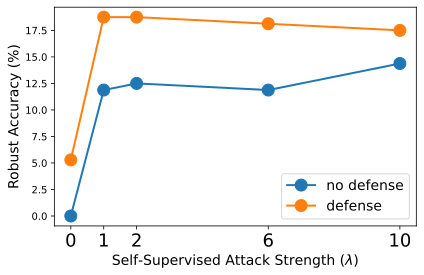

In [22]:
lambda_s = [0,2,6,10]
acc1_list = [0]
acc2_list = [5.29]
for ls in lambda_s: 
    filename = '../output/reconstruct_mae_pretrain_model/daa_acc_ls' + str(ls) + '.npy'
    _, acc1, acc2 = np.load(filename)
    
    acc1_list.append(acc1*100)
    acc2_list.append(acc2*100)
print(acc1_list)
print(acc2_list)

lambda_s = [0, 1, 2, 6, 10]

plt.plot(lambda_s, acc1_list, '-o', markersize=12, label='no defense')
plt.plot(lambda_s, acc2_list, '-o', markersize=12, label='defense')

my_xticks = ['0','1','2','6','10']
plt.xticks(lambda_s, my_xticks,  fontsize=18)
# plt.yticks(fontsize=20)
plt.title('', fontsize=18)
plt.grid(False)

plt.xlabel(r'Self-Supervised Attack Strength ($\lambda$)', fontsize=14)
plt.ylabel('Robust Accuracy (%)',fontsize=14)
plt.legend(fontsize=14, loc='lower right')
plt.tight_layout()
plt.show()

In [2]:
import os
dirpath = '../output/reconstruct_mae_v2_pretrain_model/attack_iters_log'
attack_acc_list =[]
attack_loss_list = []
filedir = os.listdir(dirpath)
for f in sorted(filedir):
    print(f)
    loss_list = []
    acc1_list =[]
    log_path = os.path.join(dirpath, f)
    with open(log_path) as f:
        lines = f.readlines()
        for l in lines:
            acc1_list.append(float(l.split(" ")[6].split("%")[0]))
            loss_list.append(float(l.split(" ")[4]))
    attack_acc_list.append(acc1_list)
    attack_loss_list.append(loss_list)

apgd_attack_iters_log.txt
bim8_attack_iters_log.txt
cwl2_attack_iters_log.txt
fgsm4_attack_iters_log.txt
fgsm8_attack_iters_log.txt
original_attack_iters_log.txt
pgd16_attack_iters_log.txt
pgd8_attack_iters_log.txt
pgdl2_attack_iters_log.txt


In [3]:
attack_acc_list

[[19.39, 23.85, 26.0, 28.18, 28.12],
 [16.94, 19.48, 21.2, 24.15, 24.17],
 [26.61, 34.47, 37.09, 38.43, 37.55],
 [19.24, 22.39, 24.5, 27.21, 27.23, 27.3],
 [12.83, 14.52, 16.1, 18.75, 18.85, 18.83],
 [75.34, 72.52, 71.85, 70.07, 69.27, 68.87],
 [11.24, 12.47, 13.6, 16.11, 16.41],
 [16.16, 18.33, 20.04, 22.87, 23.01],
 [26.45, 34.41, 36.92, 38.25, 37.5]]

In [4]:
attack_loss_list

[[0.74, 0.75, 0.72, 0.68, 0.68],
 [0.76, 0.77, 0.74, 0.7, 0.69],
 [0.71, 0.73, 0.7, 0.66, 0.65],
 [0.75, 0.76, 0.73, 0.69, 0.68, 0.68],
 [0.78, 0.79, 0.76, 0.73, 0.72, 0.72],
 [0.65, 0.67, 0.66, 0.63, 0.63, 0.63],
 [0.8, 0.8, 0.78, 0.74, 0.73],
 [0.77, 0.77, 0.74, 0.7, 0.69],
 [0.71, 0.73, 0.7, 0.66, 0.65]]

[-2.0, 0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0]


/tmp/ipykernel_476818/3968094100.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(my_xticks)
/tmp/ipykernel_476818/3968094100.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(my_xticks)


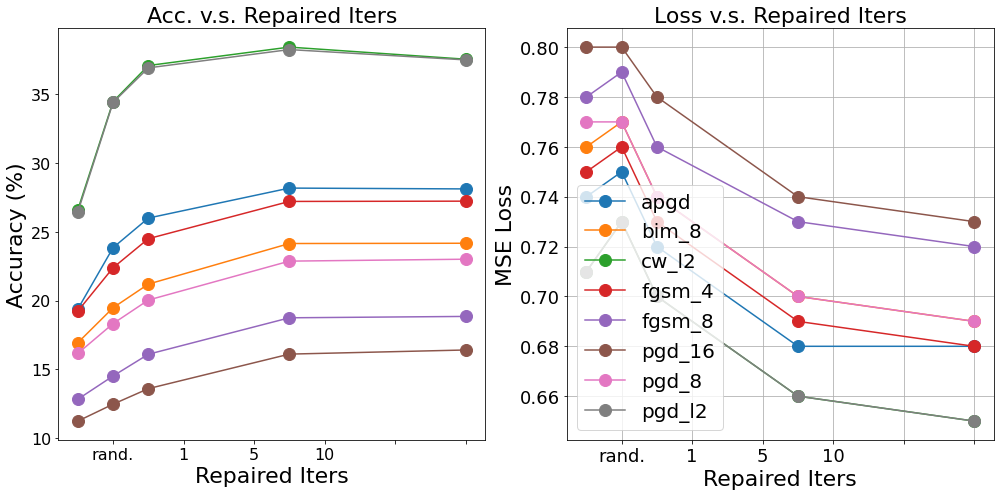

In [5]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(14, 7))      



label_list=['apgd', 'bim_8', 'cw_l2', 'fgsm_4', 'fgsm_8', 'original', 'pgd_16', 'pgd_8', 'pgd_l2']
attack_iters = [-1, 0, 1, 5, 10]
my_xticks = ['w/o','rand.','1','5', '10']

for i in range(len(label_list)):
    if label_list[i] != 'original':
        axs[0].plot(attack_iters, attack_acc_list[i][:len(attack_iters)], '-o', markersize=12, label=label_list[i])

axs[0].tick_params(axis='both', which='major', labelsize=16)
axs[0].set_title('Acc. v.s. Repaired Iters', fontsize=22)
axs[0].set_xlabel('Repaired Iters', fontsize=22)
axs[0].set_ylabel('Accuracy (%)',fontsize=22)
print(axs[0].get_xticks().tolist())
axs[0].set_xticklabels(my_xticks)


for i in range(len(label_list)):
    if label_list[i] != 'original':
        plt.plot(attack_iters, attack_loss_list[i][:len(attack_iters)], '-o', markersize=12, label=label_list[i])

axs[1].tick_params(axis='both', which='major', labelsize=18)
axs[1].set_title('Loss v.s. Repaired Iters', fontsize=22)
axs[1].set_xlabel('Repaired Iters', fontsize=22)
axs[1].set_ylabel('MSE Loss', fontsize=22)
axs[1].set_xticklabels(my_xticks)


plt.legend(fontsize=20, loc='lower left')
plt.tight_layout()
plt.grid(True)
plt.show()
# plt.savefig('attack_iters_vs_acc.png', dpi=200)

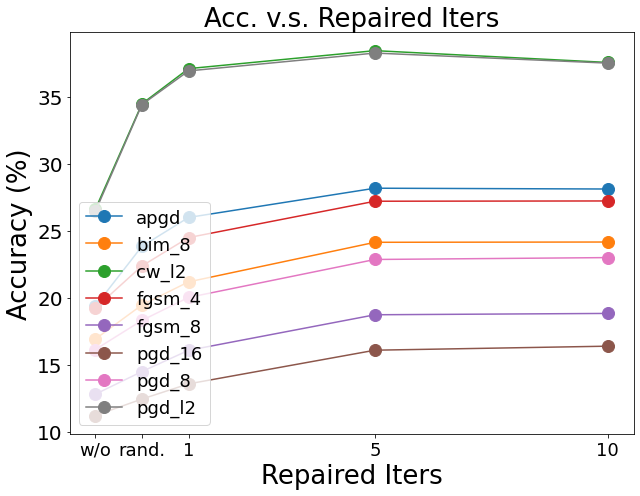

In [13]:
import matplotlib.pyplot as plt

label_list=['apgd', 'bim_8', 'cw_l2', 'fgsm_4', 'fgsm_8', 'original', 'pgd_16', 'pgd_8', 'pgd_l2']
attack_iters = [-1, 0, 1, 5, 10]
plt.figure(figsize=(9,7))
for i in range(len(label_list)):
    if label_list[i] != 'original':
        plt.plot(attack_iters, attack_acc_list[i][:len(attack_iters)], '-o', markersize=12, label=label_list[i])

my_xticks = ['w/o','rand.','1','5', '10']
plt.xticks(attack_iters, my_xticks,  fontsize=18)
plt.yticks(fontsize=20)
plt.title('Acc. v.s. Repaired Iters', fontsize=26)
plt.grid(False)

plt.xlabel('Repaired Iters', fontsize=26)
plt.ylabel('Accuracy (%)',fontsize=26)
plt.legend(fontsize=18, loc='lower left')
plt.tight_layout()
plt.savefig('attack_iters_vs_acc.png', dpi=200)

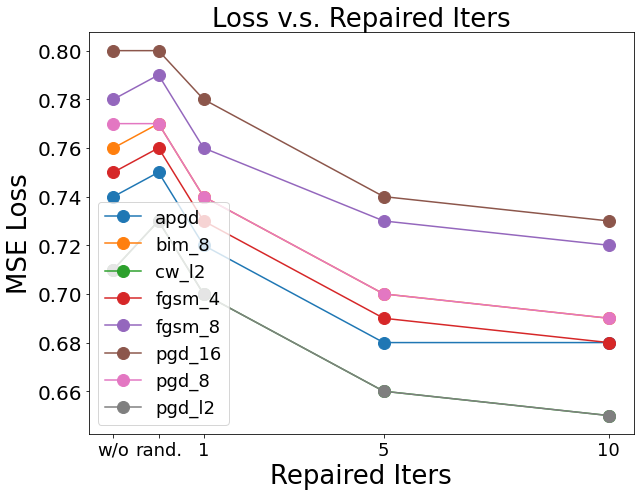

In [14]:
label_list=['apgd', 'bim_8', 'cw_l2', 'fgsm_4', 'fgsm_8', 'original', 'pgd_16', 'pgd_8', 'pgd_l2']
attack_iters = [-1, 0, 1, 5, 10]

plt.figure(figsize=(9,7))
for i in range(len(label_list)):
    if label_list[i] != 'original':
        plt.plot(attack_iters, attack_loss_list[i][:len(attack_iters)], '-o', markersize=12, label=label_list[i])
# plt.plot(attack_iters, attack_loss_list[i])
my_xticks = ['w/o','rand.','1','5', '10']

plt.xticks(attack_iters, my_xticks,  fontsize=18)
plt.yticks(fontsize=20)
plt.grid(True)
plt.title('Loss v.s. Repaired Iters', fontsize=26)
plt.xlabel('Repaired Iters', fontsize=26)
plt.ylabel('MSE Loss', fontsize=26)
plt.legend(fontsize=18, loc='lower left')
plt.tight_layout()
plt.grid(False)
plt.savefig('attack_iters_vs_loss.png', dpi=400)

In [10]:
import os
dirpath = '../output/reconstruct_mae_v2_pretrain_model/epsilon_log'
epsilon_acc_list =[]
epsilon_loss_list = []
filedir = os.listdir(dirpath)
for f in filedir:
    print(f)
    loss2_list = []
    acc2_list =[]
    log_path = os.path.join(dirpath, f)
    with open(log_path) as f:
        lines = f.readlines()
        for l in lines:
#             print(float(l.split(" ")[5].split("%")[0]))
            print(l.split(","))
            acc2_list.append(float(l.split(",")[3].split(": ")[1].split("%")[0]))
            loss2_list.append(float(l.split(",")[2].split(": ")[1]))
    epsilon_acc_list.append(acc2_list)
    epsilon_loss_list.append(loss2_list)

bim8_epsilon.log.txt
['eps: 0.00784313725490196', ' attack_iter: 5', ' loss: 0.73', ' acc1: 18.74%', ' acc5: 40.89%\n']
['eps: 0.01568627450980392', ' attack_iter: 5', ' loss: 0.71', ' acc1: 21.03%', ' acc5: 44.44%\n']
['eps: 0.03137254901960784', ' attack_iter: 5', ' loss: 0.70', ' acc1: 24.10%', ' acc5: 49.05%\n']
['eps: 0.06274509803921569', ' attack_iter: 5', ' loss: 0.70', ' acc1: 27.41%', ' acc5: 53.64%\n']
cwl2_epsilon.log.txt
['eps: 0.00784313725490196', ' attack_iter: 5', ' loss: 0.68', ' acc1: 31.29%', ' acc5: 58.75%\n']
['eps: 0.01568627450980392', ' attack_iter: 5', ' loss: 0.66', ' acc1: 35.27%', ' acc5: 63.01%\n']
['eps: 0.03137254901960784', ' attack_iter: 5', ' loss: 0.66', ' acc1: 38.45%', ' acc5: 66.51%\n']
['eps: 0.06274509803921569', ' attack_iter: 5', ' loss: 0.66', ' acc1: 40.67%', ' acc5: 68.83%\n']
fgsm8_epsilon.log.txt
['eps: 0.00784313725490196', ' attack_iter: 5', ' loss: 0.76', ' acc1: 14.24%', ' acc5: 33.63%\n']
['eps: 0.01568627450980392', ' attack_iter: 5

In [11]:
epsilon_acc_list

[[18.74, 21.03, 24.1, 27.41],
 [31.29, 35.27, 38.45, 40.67],
 [14.24, 16.35, 18.8, 20.93],
 [21.29, 24.04, 27.35, 30.96],
 [31.23, 35.13, 38.28, 40.27],
 [17.74, 19.96, 23.0, 26.13],
 [22.29, 25.34, 28.39, 30.96],
 [12.41, 14.18, 16.2, 17.83]]

In [12]:
epsilon_loss_list

[[0.73, 0.71, 0.7, 0.7],
 [0.68, 0.66, 0.66, 0.66],
 [0.76, 0.74, 0.73, 0.72],
 [0.72, 0.7, 0.69, 0.69],
 [0.68, 0.66, 0.66, 0.66],
 [0.74, 0.72, 0.7, 0.7],
 [0.71, 0.7, 0.68, 0.69],
 [0.77, 0.75, 0.74, 0.74]]

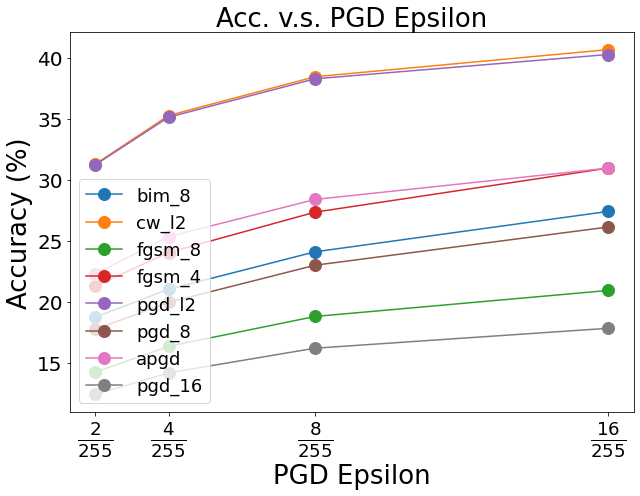

In [15]:
import matplotlib.pyplot as plt

label_list=['bim_8', 'cw_l2', 'fgsm_8', 'fgsm_4', 'pgd_l2', 'pgd_8', 'apgd', 'pgd_16']
eps_list = [2/255, 4/255, 8/255, 16/255]
plt.figure(figsize=(9,7))
plt.grid(False)
for i in range(len(epsilon_acc_list)):
    plt.plot(eps_list, epsilon_acc_list[i], '-o', markersize=12, label=label_list[i])

myticks = [r"$\frac{2}{255}$",r"$\frac{4}{255}$",r"$\frac{8}{255}$",r"$\frac{16}{255}$"]
plt.xticks(eps_list, myticks ,fontsize=26)
plt.yticks(fontsize=20)

plt.title('Acc. v.s. PGD Epsilon', fontsize=26)
plt.xlabel('PGD Epsilon', fontsize=26)
plt.ylabel('Accuracy (%)', fontsize=26)
plt.legend(fontsize=18, loc='lower left')
plt.tight_layout()
plt.savefig('epsilon_vs_acc.png', dpi=400)

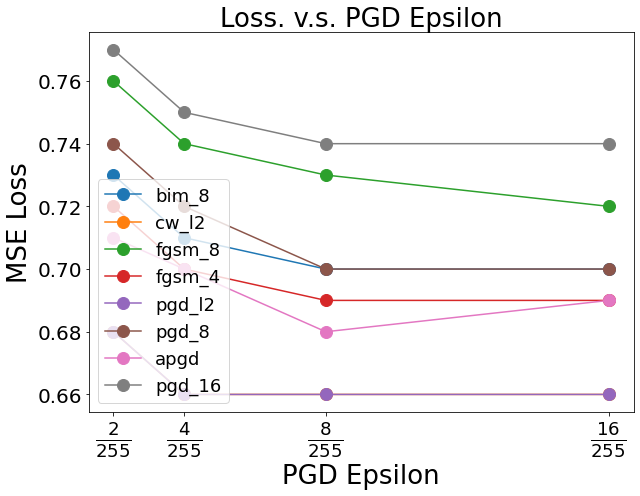

In [16]:
import matplotlib.pyplot as plt

label_list=['bim_8', 'cw_l2', 'fgsm_8', 'fgsm_4', 'pgd_l2', 'pgd_8', 'apgd', 'pgd_16']
eps_list = [2/255, 4/255, 8/255, 16/255]
plt.figure(figsize=(9,7))
for i in range(len(epsilon_loss_list)):
    plt.plot(eps_list, epsilon_loss_list[i], '-o', markersize=12, label=label_list[i])

myticks = [r"$\frac{2}{255}$",r"$\frac{4}{255}$",r"$\frac{8}{255}$",r"$\frac{16}{255}$"]
plt.xticks(eps_list, myticks ,fontsize=26)
plt.yticks(fontsize=20)
plt.grid(False)
plt.title('Loss. v.s. PGD Epsilon', fontsize=26)
plt.xlabel('PGD Epsilon', fontsize=26)
plt.ylabel('MSE Loss', fontsize=26)
plt.legend(fontsize=18, loc='lower left')
plt.tight_layout()
plt.savefig('epsilon_vs_loss.png', dpi=400)

0 0
0 1
0 2
0 3
1 0
1 1
1 2
1 3


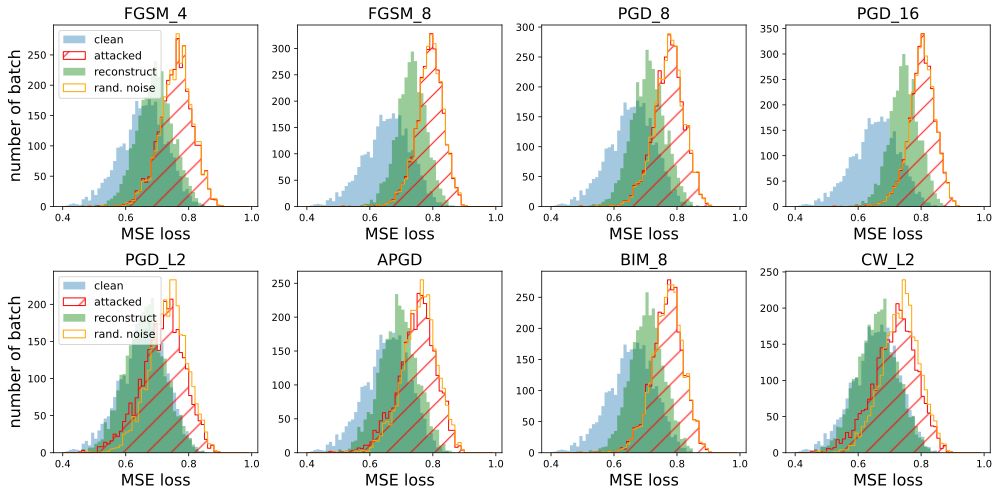

In [3]:
import os
import numpy as np
import matplotlib.mlab as mlab
dirpath = '../output/reconstruct_mae_v2_pretrain_model/mse_loss_log'
epsilon_acc_list =[]
epsilon_loss_list = []
filedir = os.listdir(dirpath)
attack_list = ['fgsm4', 'fgsm8', 'pgd8', 'pgd16', 'pgdl2','apgd', 'bim', 'cwl2', ]
Att_name = ['FGSM_4', 'FGSM_8', 'PGD_8', 'PGD_16', 'PGD_L2','APGD', 'BIM_8', 'CW_L2']

clean_loss_array = np.load(os.path.join(dirpath, 'clean_loss.npy'))

fig, axs = plt.subplots(2, 4, figsize=(14, 7))                         
for i in range(len(attack_list)):

    loss_list = []
    loss_list.append(clean_loss_array[0])
                           
    loss_log_path = os.path.join(dirpath, attack_list[i] + '_loss.npy')
    noise_loss_log_path = os.path.join(dirpath, attack_list[i] + '_noise_loss.npy')
    
    loss_array = np.load(loss_log_path)
    noise_loss_array = np.load(noise_loss_log_path)

    loss_list.append(loss_array[0])
    loss_list.append(loss_array[1])
    loss_list.append(noise_loss_array[1])
    
    clean_loss = np.round(loss_list[0],2)
    before_loss = np.round(loss_list[1],2)
    reverse_loss = np.round(loss_list[2],2)
    noise_loss = np.round(loss_list[3],2)
    print(i//4, i%4)
    axs[i//4, i%4].hist(clean_loss, bins=np.arange(40, 100)/100, histtype='stepfilled', alpha = 0.4, label='clean')
    axs[i//4, i%4].hist(before_loss, bins=np.arange(40, 100)/100, color='red', histtype='step', label='attacked', hatch='/')
    axs[i//4, i%4].hist(reverse_loss, bins=np.arange(40, 100)/100, color='green', histtype='stepfilled', alpha = 0.4, label='reconstruct')
    axs[i//4, i%4].hist(noise_loss, bins=np.arange(40, 100)/100, color='orange', histtype='step' , label='rand. noise')
                           
    axs[i//4, i%4].set_title(f'{Att_name[i]}', fontsize=16)
    axs[i//4, i%4].set_xlabel('MSE loss', fontsize=16)
    if i%4==0:
        axs[i//4, i%4].set_ylabel('number of batch', fontsize=16)
        axs[i//4, i%4].legend(loc='upper left', fontsize=11)
plt.tight_layout()
plt.savefig('mse_loss_distribution.png', dpi=400)

## Detection baseline: L1 Norm Detection 
$\delta = \| h(x) − h(x + p) \|_1$. 
The input x is rejected as adversarial if $\delta$ is sufficiently large.

PGD_8 : tp  0.97552  | fn  0.02448  | fp  0.62624  | tn  0.37376
Threshold:  2.7445743999999994
Detection Accuracy:  0.67464


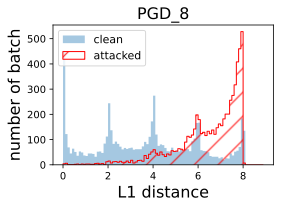

PGD_16 : tp  0.98576  | fn  0.01424  | fp  0.62064  | tn  0.37936
Threshold:  2.6792767999999993
Detection Accuracy:  0.68256


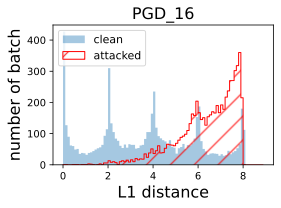

FGSM_4 : tp  0.97472  | fn  0.02528  | fp  0.63664  | tn  0.36336
Threshold:  2.6592415999999988
Detection Accuracy:  0.66904


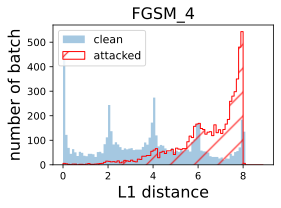

FGSM_8 : tp  0.98032  | fn  0.01968  | fp  0.61984  | tn  0.38016
Threshold:  2.6810703999999994
Detection Accuracy:  0.68024


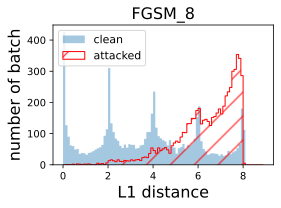

CW_L2 : tp  0.96928  | fn  0.03072  | fp  0.6576  | tn  0.3424
Threshold:  2.46748
Detection Accuracy:  0.65584


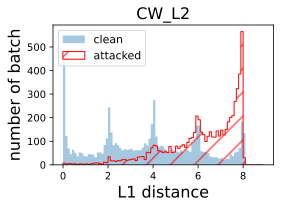

In [29]:
import os
import numpy as np
import matplotlib.mlab as mlab
dirpath = '../output/reconstruct_mae_v2_pretrain_model/mse_loss_log'
epsilon_acc_list =[]
epsilon_loss_list = []
filedir = os.listdir(dirpath)
# attack_list = ['fgsm4', 'fgsm8', 'pgd8', 'pgd16', 'pgdl2','apgd', 'bim', 'cwl2', ]
attack_list = ['pgd8', 'pgd16', 'fgsm4', 'fgsm8', 'cw2']
# Att_name = ['FGSM_4', 'FGSM_8', 'PGD_8', 'PGD_16', 'PGD_L2','APGD', 'BIM_8', 'CW_L2']
Att_name = ['PGD_8', 'PGD_16', 'FGSM_4', 'FGSM_8', 'CW_L2']

                      
for i in range(5):
    plt.figure(figsize=(4,3))
    loss_list = []
    tp, fn, fp, tn  = 0, 0, 0, 0
    loss_log_path = '../output/l1_dist_' + attack_list[i] + '.npy'
    loss_array = np.load(loss_log_path)

    loss_list.append(loss_array[0])
    loss_list.append(loss_array[1])


    clean_loss = np.round(loss_list[0],2)
    adv_loss = np.round(loss_list[1],2)
    
    threshold = adv_loss.mean() - clean_loss.mean()
    
    
    for j in range(len(adv_loss)):
        if adv_loss[j] > threshold:
            tp += 1
        elif adv_loss[j] < threshold:
            fn += 1
    for j in range(len(clean_loss)):
        if clean_loss[j] > threshold:
            fp += 1
        elif clean_loss[j] < threshold:
            tn += 1

    plt.hist(clean_loss, bins=np.arange(0, 90)/10, histtype='stepfilled', alpha = 0.4, label='clean')
    plt.hist(adv_loss, bins=np.arange(0, 90)/10, color='red', histtype='step', label='attacked', hatch='/')


    plt.title(f'{Att_name[i]}', fontsize=16)
    plt.xlabel('L1 distance', fontsize=16)
    plt.ylabel('number of batch', fontsize=16)
    plt.legend(loc='upper left', fontsize=11)
    print(Att_name[i], ": tp ", tp/len(adv_loss), " | fn ", fn/len(adv_loss), " | fp ", fp/len(clean_loss),  " | tn ", tn/len(clean_loss))
    print('Threshold: ', threshold)
    print('Detection Accuracy: ', (tp+tn)/(len(adv_loss) + len(clean_loss)))
    plt.tight_layout()
    plt.show()
# plt.savefig('l1_distance_pgd16.png', dpi=400)

##### 